In [11]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("Steam Reviews Analysis").getOrCreate()

In [12]:
# Load the dataset
df = spark.read.csv("clean_sample.csv", header=True, inferSchema=True)

# Preview the schema
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_votes: integer (nullable = true)
 |-- sentiment_label_textblob: string (nullable = true)
 |-- sentiment_label_vader: string (nullable = true)
 |-- sentiment_combined: string (nullable = true)



In [13]:
# Register temporary SQL view
df.createOrReplaceTempView("reviews")

In [14]:
# SQL query: negative review ratio per game
query = """
SELECT 
    app_name,
    COUNT(*) AS total_reviews,
    SUM(CASE WHEN LOWER(sentiment_combined) = 'negative' THEN 1 ELSE 0 END) AS negative_reviews,
    ROUND(
        SUM(CASE WHEN LOWER(sentiment_combined) = 'negative' THEN 1 ELSE 0 END) * 1.0 / COUNT(*),
        3
    ) AS negative_ratio
FROM reviews
WHERE app_name IS NOT NULL
GROUP BY app_name
HAVING COUNT(*) > 100
ORDER BY negative_ratio DESC
LIMIT 20
"""

# Execute the query
negative_by_game = spark.sql(query)

In [15]:
# Show the results
negative_by_game.show(truncate=False)

+--------------------------------+-------------+----------------+--------------+
|app_name                        |total_reviews|negative_reviews|negative_ratio|
+--------------------------------+-------------+----------------+--------------+
|Postal 3                        |579          |165             |0.285         |
|WARP                            |138          |29              |0.210         |
|Disciples III: Reincarnation    |145          |28              |0.193         |
|Super Monday Night Combat       |2457         |431             |0.175         |
|A.V.A. Alliance of Valiant Arms™|5067         |778             |0.154         |
|Prototype                       |1147         |162             |0.141         |
|TimeShift                       |295          |41              |0.139         |
|Shank 2                         |505          |68              |0.135         |
|ORION: Prelude                  |1115         |131             |0.117         |
|Runespell: Overture        

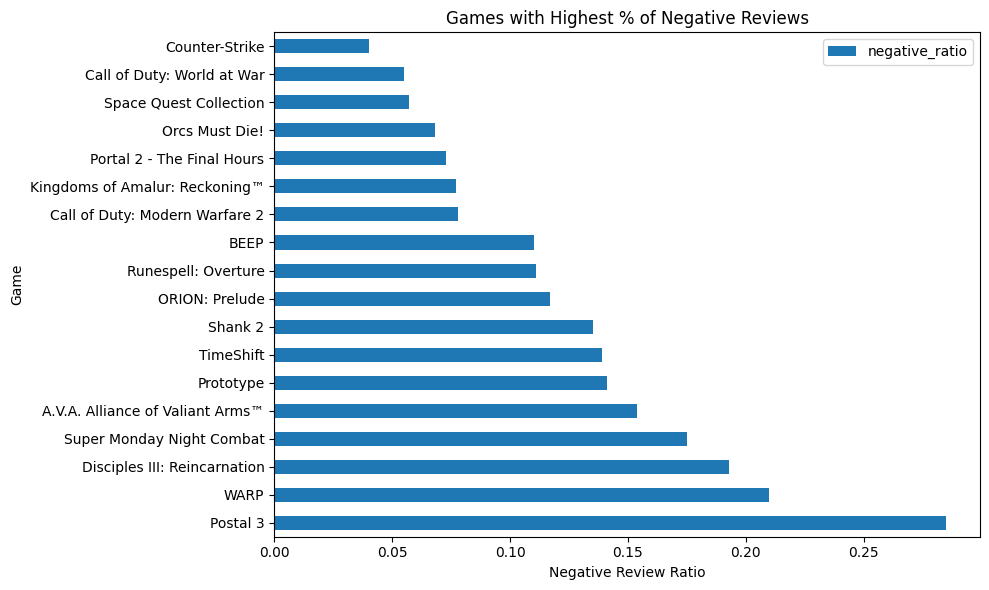

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
pdf = negative_by_game.toPandas()

# Ensure the column is numeric
pdf["negative_ratio"] = pd.to_numeric(pdf["negative_ratio"], errors="coerce")

# Sort and select top 20
pdf = pdf.sort_values(by="negative_ratio", ascending=False).head(20)

# Plot
pdf.plot(x="app_name", y="negative_ratio", kind="barh", figsize=(10, 6))
plt.title("Games with Highest % of Negative Reviews")
plt.xlabel("Negative Review Ratio")
plt.ylabel("Game")
plt.tight_layout()
plt.show()